In [2]:
import torch
import numpy as np
import os
import pandas as pd
from torch.utils.data import DataLoader
import gc

from dataset import BuildingDataset, collate_fn, TestDataset, test_collate_fn, train_df_create, test_df_create
from model import CustomMaskRCNNBackbone, CUSTOM_MaskRCNN, Custom_Transformer_UNet
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from matplotlib import pyplot as plt

In [3]:
from train import load_model, load_data

In [4]:
checkpoint_path = "/home/deependra/kuyesera/dahircnn/checkpoints/best_model.pth"
model = load_model(checkpoint_path)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)

using UNet Encoder with resnet18 !!!!
Model weights loaded from /home/deependra/kuyesera/dahircnn/checkpoints/best_model.pth


In [5]:
damage_class_to_id = {
    "no-damage": 1,
    "minor-damage": 2,
    "major-damage": 3,
    "destroyed": 4,
}

id_to_damage_class = {v: k for k, v in damage_class_to_id.items()}

In [6]:
def predict_and_count(model, data_loader, device, score_threshold=0.5):
    model.eval()
    image_counts = []

    with torch.no_grad():
        for imgs, img_ids in tqdm(data_loader, desc="Processing images"):
            imgs = list(image.to(device) for image in imgs)

            outputs = model(imgs)

            for i, output in enumerate(outputs):
                img_id = img_ids[i]

                scores = output["scores"].cpu()
                keep = scores >= score_threshold
                labels = output["labels"][keep].cpu().numpy()

                counts = {class_name: 0 for class_name in damage_class_to_id.keys()}
                for label in labels:
                    class_name = id_to_damage_class.get(label, "unknown")
                    if class_name in counts:
                        counts[class_name] += 1

                # Store the results for this image
                image_counts.append({"img_id": img_id, "counts": counts})

    return image_counts

In [7]:
score_threshold = 0.5

In [8]:
_, test_loader, val_loader = load_data(batch_size=2, split="tier1")

Loading test_df from file
Loading train_df from file
Loading hold_df from file
Train data loading complete
Test data loading complete


In [ ]:
model.eval()
image_counts = []

with torch.no_grad():
    for imgs, img_ids in tqdm(test_loader, desc="Processing images"):
        imgs = [image.to(device) for image in imgs]

        outputs = model(imgs)

        for i, output in enumerate(outputs):
            img_id = img_ids[i]

            scores = output["scores"].cpu()
            keep = scores >= score_threshold
            labels = output["labels"][keep].cpu().numpy()
            masks = output["masks"][keep].cpu().numpy()

            img = imgs[0][:3].cpu().numpy().transpose(1, 2, 0)  
            
            for i in range(len(labels)):
                # mask = masks[0][0] 
                mask = masks[i][0]
                
                # print(labels)
                # print(f"unique values in mask: {np.unique(mask)}")

                fig, ax = plt.subplots(figsize=(8, 8))
                ax.imshow(img)  
                
                ax.imshow(mask, cmap='jet', alpha=0.4)  

                ax.axis("off")  
                plt.show()
        
        break
        # overall_mask = np.zeros((1024, 1024))
        
        # for i in range(len(labels)):
        #     # print(f"Label: {labels[i]}, Mask shape: {masks[i].shape}")
        #     mask = masks[i][0]

        #     # set values greater than 0 to label id
        #     mask[mask > 0] = labels[i]
        #     overall_mask += mask
        
        # print(f"unique values in overall mask: {np.unique(overall_mask)}")
        
        # fig, ax = plt.subplots(figsize=(8, 8))
        # ax.imshow(img)
        # ax.imshow(overall_mask, cmap='jet', alpha=0.2)
        # ax.axis("off")
        # plt.show()
            
        # break  # Remove this if y

Processing images:   0%|          | 0/348 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[5.18552612e+02 2.12830643e+02 5.72330811e+02 2.76502991e+02]
 [2.02934189e+02 1.28054626e+02 2.72169678e+02 1.97345886e+02]
 [4.06110764e-01 3.95364685e+02 4.90030746e+01 4.54646973e+02]
 [2.94234123e+01 4.84614677e+01 9.66561279e+01 1.20763824e+02]
 [3.46627350e+02 4.40023010e+02 3.75997223e+02 4.52163269e+02]
 [5.96111389e+02 7.16834412e+01 6.89153870e+02 1.97248077e+02]
 [6.56326416e+02 5.76938629e-01 7.24012085e+02 7.68104401e+01]
 [1.50896042e+02 1.51614746e+02 1.82621384e+02 1.86520355e+02]
 [4.78723602e+02 2.41404251e+02 5.21187500e+02 2.88112640e+02]
 [0.00000000e+00 2.10577774e+02 3.06442356e+01 2.46136337e+02]
 [7.27371216e+02 3.99198532e+00 7.71769775e+02 8.16354065e+01]
 [5.97666504e+02 1.10440857e+02 6.32956055e+02 1.44789139e+02]
 [5.90120483e+02 7.63293152e+01 6.39253906e+02 1.25382721e+02]
 [4.68077881e+02 3.43693695e+02 5.23247864e+02 4.21282501e+02]
 [7.07081055e+02 2.42359924e+01 7.51083862e+02 9.35856400e+01]
 [2.57092041e+02 4.06877075e+02 3.14447876e+02 4.546086

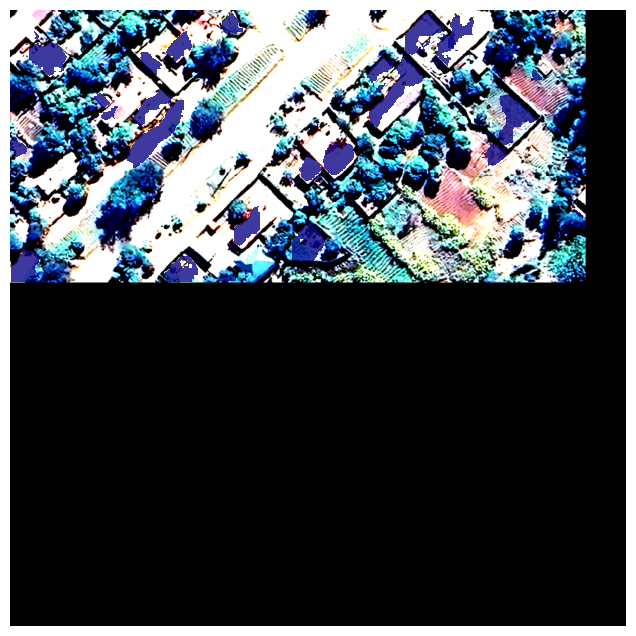

Processing images:   0%|          | 0/348 [00:05<?, ?it/s]


In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from matplotlib.patches import Polygon

model.eval()
image_counts = []

with torch.no_grad():
    for imgs, img_ids in tqdm(test_loader, desc="Processing images"):
        imgs = [image.to(device) for image in imgs]
        outputs = model(imgs)
        
        colors = ['Reds', 'Blues', 'Greens', 'Purples', 'Oranges']

        for i, output in enumerate(outputs):
            # print(outputs)
            img_id = img_ids[i]
            scores = output["scores"].cpu()
            keep = scores >= score_threshold
            labels = output["labels"][keep].cpu().numpy()
            masks = output["masks"][keep].cpu().numpy()
            boxes = output["boxes"][keep].cpu().numpy()
            print(boxes)

            img = imgs[i][:3].cpu().numpy().transpose(1, 2, 0)  # Convert tensor to image
            
            fig, ax = plt.subplots(figsize=(8, 8))
            ax.imshow(img)  # Display original image
            
            for j in range(len(labels)):
                mask = masks[j][0]  # Extract the single-channel mask
                
                # Convert to binary mask (set threshold if needed)
                binary_mask = mask > 0.5  

                # Overlay the mask
                ax.imshow(np.ma.masked_where(binary_mask == 0, binary_mask), cmap='plasma', alpha=0.8)

                # Find and plot mask contours
                # contours = find_contours(binary_mask, level=0.5)
                # for contour in contours:
                #     polygon = Polygon(contour, linewidth=2, edgecolor='red', facecolor='none')
                #     ax.add_patch(polygon)

            ax.axis("off")  
            plt.show()
        
        break  # Only process the first batch


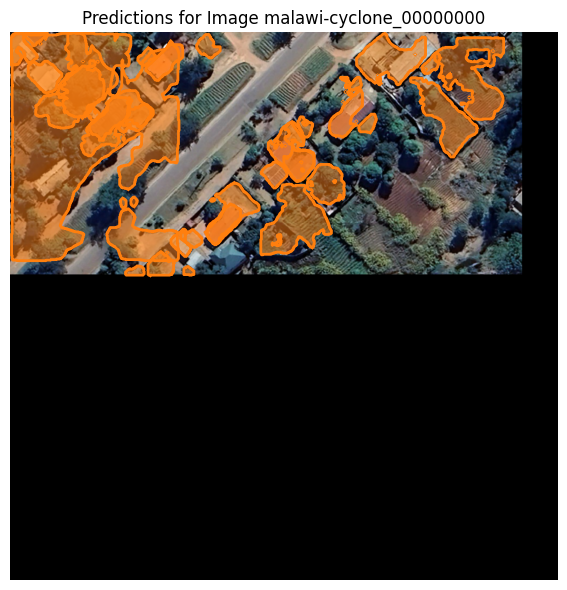

0


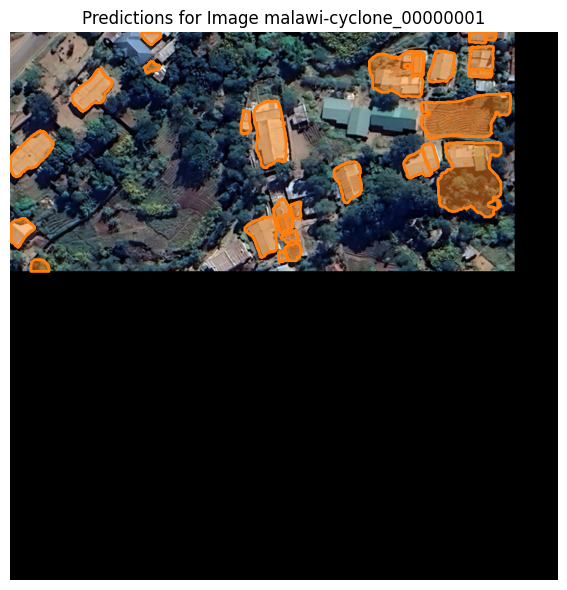

1


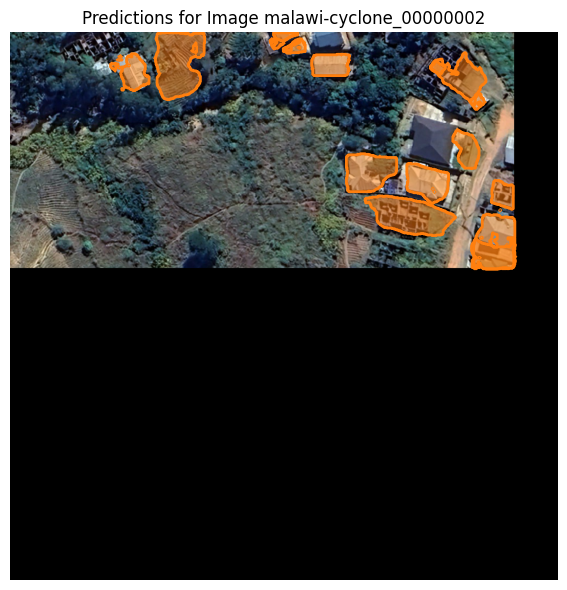

2


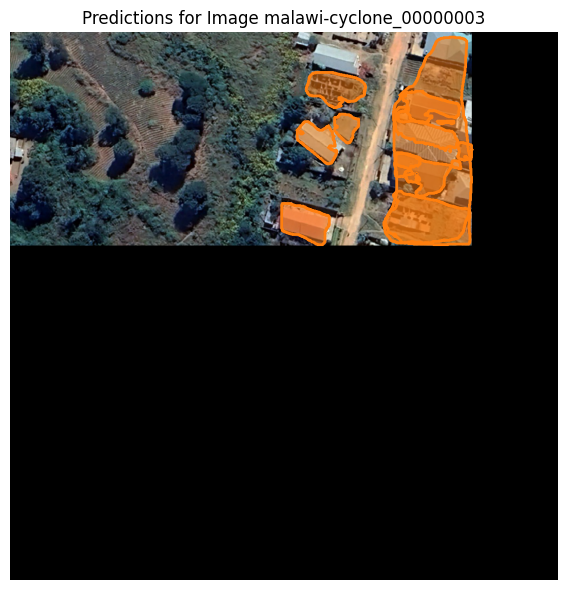

3


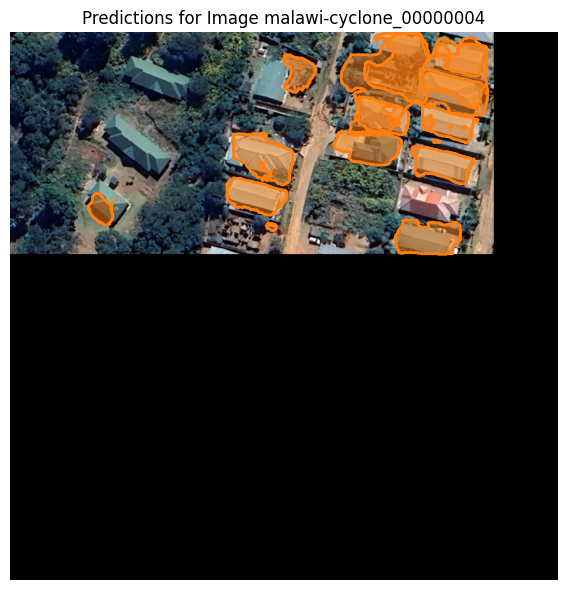

4


In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from matplotlib.patches import Polygon
from matplotlib import colors as mcolors
from tqdm import tqdm

# Generate distinct colors using Matplotlib color palette
color_list = list(mcolors.TABLEAU_COLORS.values())  # Predefined distinct colors
num_colors = len(color_list)

model.eval()
image_counts = []

with torch.no_grad():
    for k, (imgs, img_ids) in enumerate(test_loader):
        imgs = [image.to(device) for image in imgs]
        outputs = model(imgs)

        for i, output in enumerate(outputs):
            img_id = img_ids[i]
            scores = output["scores"].cpu()
            keep = scores >= score_threshold  # Apply score threshold
            labels = output["labels"][keep].cpu().numpy()
            masks = output["masks"][keep].cpu().numpy()
            boxes = output["boxes"][keep].cpu().numpy()

            img = imgs[i][:3].cpu().numpy().transpose(1, 2, 0)  # Convert tensor to image
            
            # Create figure
            fig, ax = plt.subplots(figsize=(6, 6))
            ax.imshow(img)  # Display original image
            ax.set_title(f"Predictions for Image {img_id}")

            for j in range(len(labels)):
                mask = masks[j][0]  # Extract single-channel mask
                binary_mask = mask > 0.5  # Convert to binary mask
                
                # Assign a unique color based on label
                color = color_list[labels[j] % num_colors]

                # Overlay mask with the selected color
                ax.imshow(np.ma.masked_where(binary_mask == 0, binary_mask), cmap=mcolors.ListedColormap([color]), alpha=0.5)

                # Find and plot mask contours
                contours = find_contours(binary_mask, level=0.5)
                for contour in contours:
                    polygon = Polygon(contour[:, ::-1], linewidth=2, edgecolor=color, facecolor='none')
                    ax.add_patch(polygon)

            ax.axis("off")
            plt.tight_layout()
            plt.show()
        
        print(k)
        if k == 4:
            break  # Process only the first batch
        # break


Processing images:   0%|          | 0/933 [00:00<?, ?it/s]

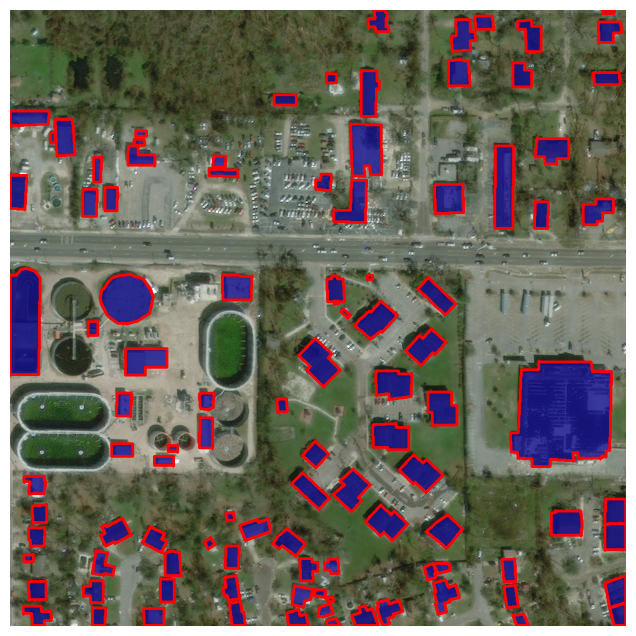

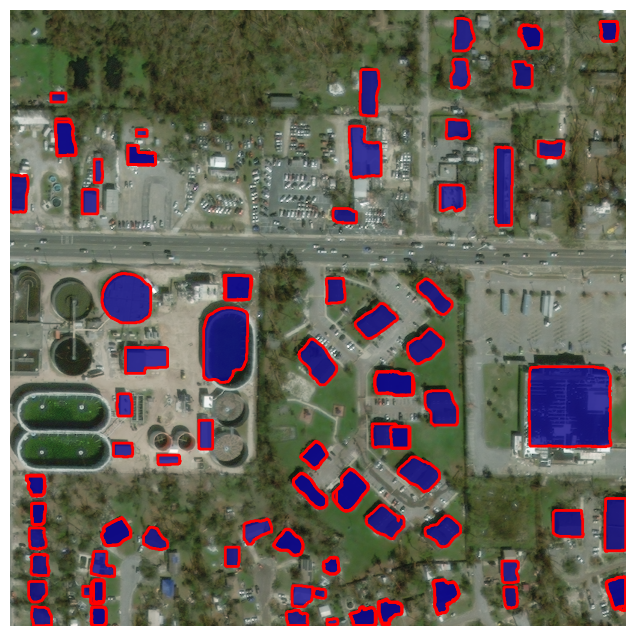

Processing images:   0%|          | 0/933 [00:33<?, ?it/s]


In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from matplotlib.patches import Polygon, Rectangle
from tqdm import tqdm

model.eval()
image_counts = []

with torch.no_grad():
    for imgs, targets, counts in tqdm(val_loader, desc="Processing images"):
        imgs = [image.to(device) for image in imgs]
        outputs = model(imgs)
        
        colors = ['Reds', 'Blues', 'Greens', 'Purples', 'Oranges']
        
        # print(targets)
        
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(img) 
        
        for i in range(len(targets[0]['labels'])):
            mask = targets[0]['masks'][i].cpu().numpy()
            binary_mask = mask > 0.5
            
            ax.imshow(np.ma.masked_where(binary_mask == 0, binary_mask), cmap='plasma', alpha=0.8)
            
            contours = find_contours(binary_mask, level=0.5)
            for contour in contours:
                polygon = Polygon(contour[:, ::-1], linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(polygon)
        
        ax.axis("off")  
        plt.show()
            

        for i, output in enumerate(outputs):
            # img_id = img_ids[i]
            scores = output["scores"].cpu()
            keep = scores >= 0.3  # Apply score threshold
            labels = output["labels"][keep].cpu().numpy()
            masks = output["masks"][keep].cpu().numpy()
            boxes = output["boxes"][keep].cpu().numpy()

            img = imgs[i][:3].cpu().numpy().transpose(1, 2, 0)  # Convert tensor to image
            
            fig, ax = plt.subplots(figsize=(8, 8))
            ax.imshow(img)  # Display original image
            
            for j in range(len(labels)):
                mask = masks[j][0]  # Extract the single-channel mask
                
                # Convert to binary mask
                binary_mask = mask > 0.5  

                # Overlay the mask
                ax.imshow(np.ma.masked_where(binary_mask == 0, binary_mask), cmap='plasma', alpha=0.8)

                # Find and plot mask contours
                contours = find_contours(binary_mask, level=0.5)
                for contour in contours:
                    polygon = Polygon(contour[:, ::-1], linewidth=2, edgecolor='red', facecolor='none')
                    ax.add_patch(polygon)

                # Draw bounding box
                # x_min, y_min, x_max, y_max = boxes[j]
                # rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                #                  linewidth=2, edgecolor='cyan', facecolor='none')
                # ax.add_patch(rect)

            ax.axis("off")  
            plt.show()
        
        break  # Remove this line if you want to process more images


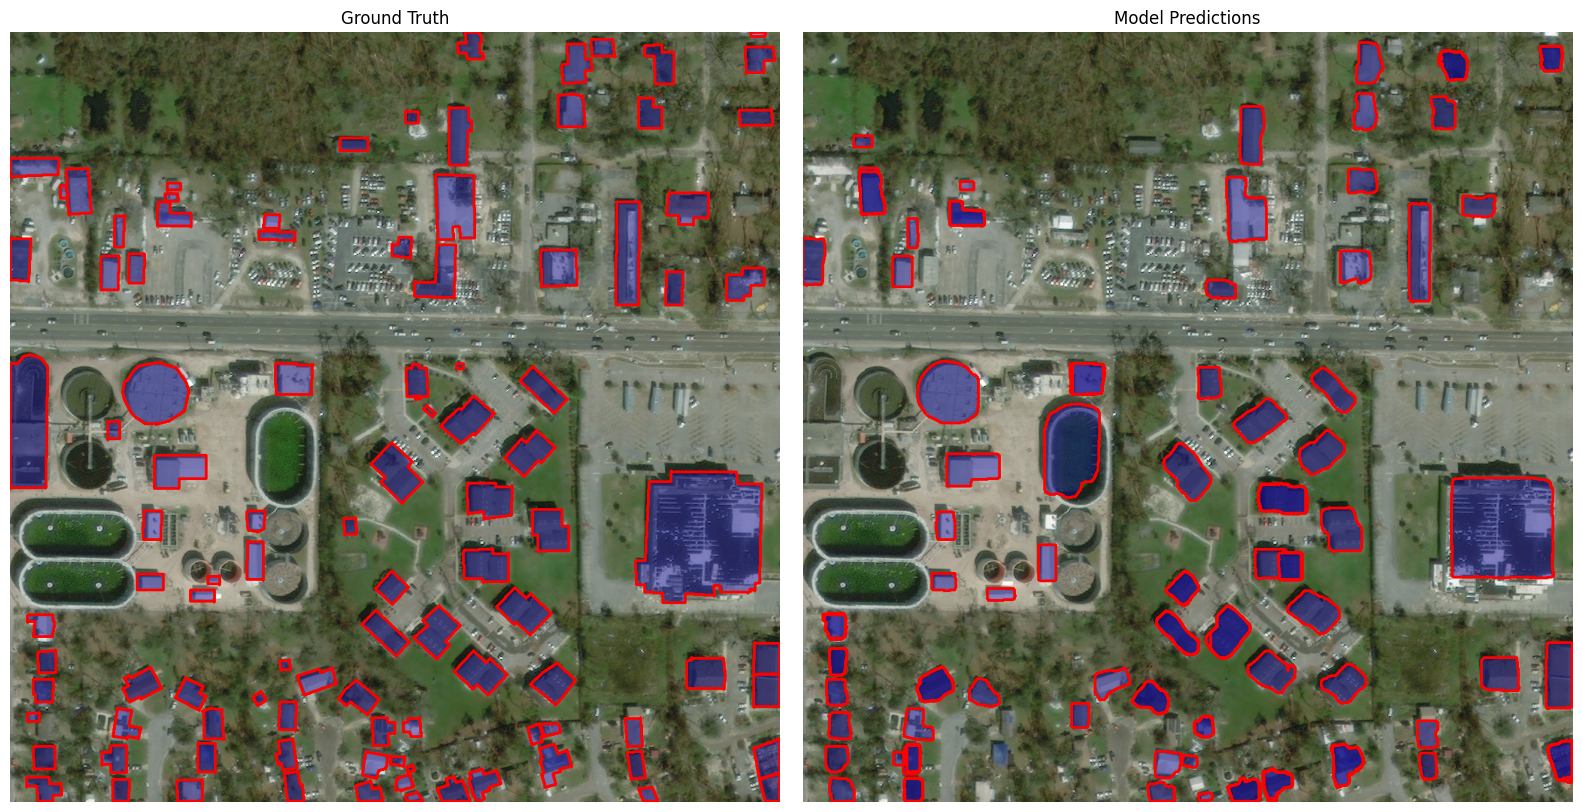

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from matplotlib.patches import Polygon
from tqdm import tqdm

model.eval()
image_counts = []

with torch.no_grad():
    for imgs, targets, counts in val_loader:
        imgs = [image.to(device) for image in imgs]
        outputs = model(imgs)
        
        for i, (img, target, output) in enumerate(zip(imgs, targets, outputs)):
            scores = output["scores"].cpu()
            keep = scores >= 0.3  # Apply score threshold
            labels = output["labels"][keep].cpu().numpy()
            masks = output["masks"][keep].cpu().numpy()
            boxes = output["boxes"][keep].cpu().numpy()

            # Convert tensor to image format (H, W, 3)
            img = img[:3].cpu().numpy().transpose(1, 2, 0)  

            # Create figure with two side-by-side subplots
            fig, axes = plt.subplots(1, 2, figsize=(16, 8))

            ### **Left: Ground Truth Masks**
            axes[0].imshow(img)  # Show the original image
            axes[0].set_title("Ground Truth")

            for j in range(len(target["labels"])):
                mask = target["masks"][j].cpu().numpy()
                binary_mask = mask > 0.5  # Convert to binary

                # Overlay mask
                axes[0].imshow(np.ma.masked_where(binary_mask == 0, binary_mask), cmap='plasma', alpha=0.5)

                # Draw contours
                contours = find_contours(binary_mask, level=0.5)
                for contour in contours:
                    polygon = Polygon(contour[:, ::-1], linewidth=2, edgecolor='red', facecolor='none')
                    axes[0].add_patch(polygon)

            axes[0].axis("off")  

            ### **Right: Model Predictions**
            axes[1].imshow(img)  # Show the original image
            axes[1].set_title("Model Predictions")

            for j in range(len(labels)):
                mask = masks[j][0]  # Extract single-channel mask
                binary_mask = mask > 0.5  # Convert to binary

                # Overlay mask
                axes[1].imshow(np.ma.masked_where(binary_mask == 0, binary_mask), cmap='plasma', alpha=0.5)

                # Draw contours
                contours = find_contours(binary_mask, level=0.5)
                for contour in contours:
                    polygon = Polygon(contour[:, ::-1], linewidth=2, edgecolor='red', facecolor='none')
                    axes[1].add_patch(polygon)

            axes[1].axis("off")

            plt.tight_layout()
            plt.show()

        break  # Remove this line to process more images


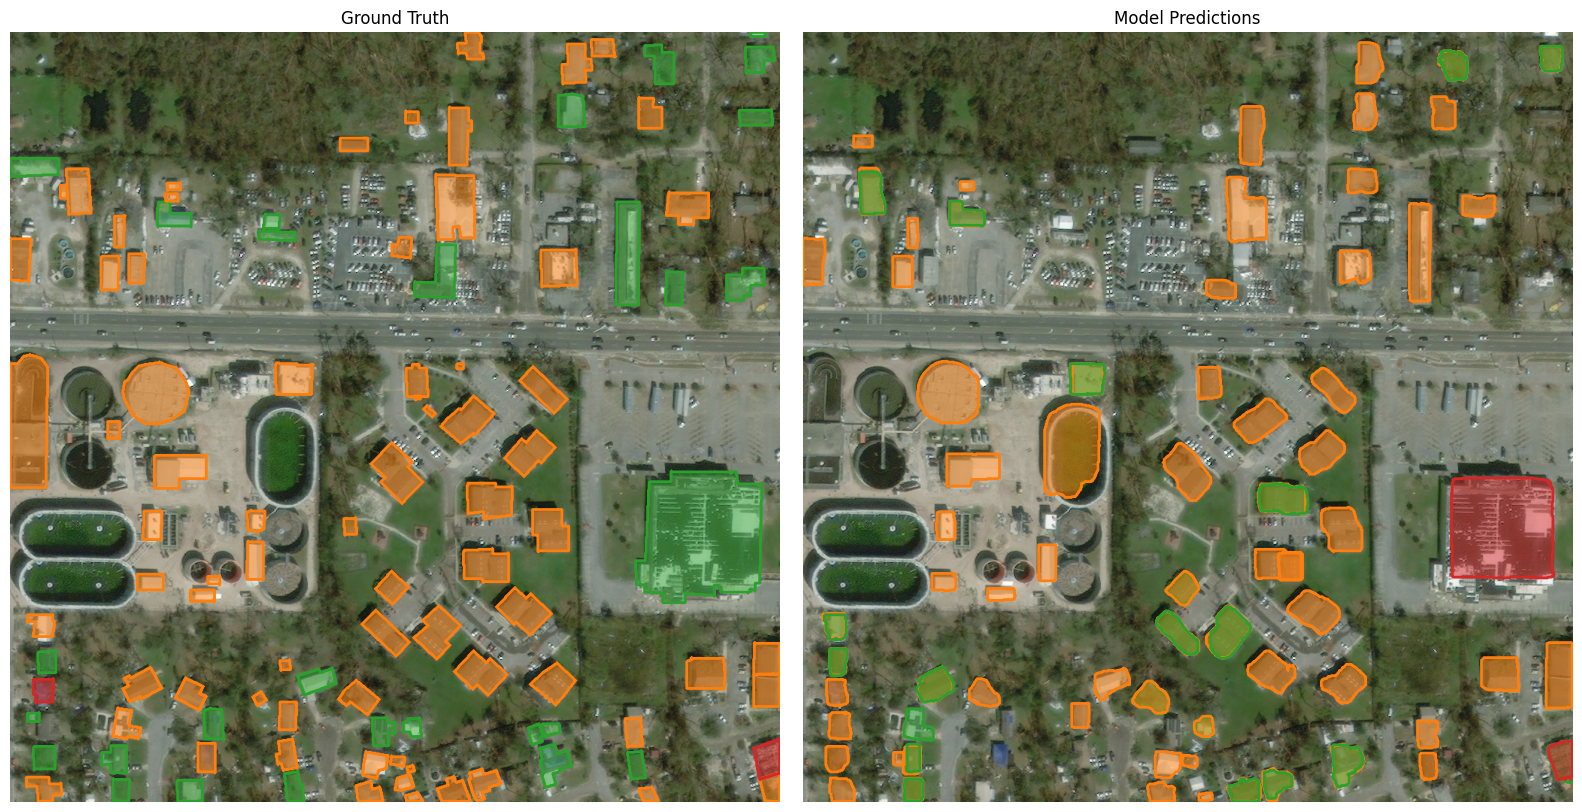

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from matplotlib.patches import Polygon
from matplotlib import colors as mcolors
from tqdm import tqdm

# Generate distinct colors using Matplotlib colormap
color_list = list(mcolors.TABLEAU_COLORS.values())  # Predefined distinct colors
num_colors = len(color_list)

model.eval()
image_counts = []

with torch.no_grad():
    for imgs, targets, counts in val_loader:
        imgs = [image.to(device) for image in imgs]
        outputs = model(imgs)
        
        for i, (img, target, output) in enumerate(zip(imgs, targets, outputs)):
            scores = output["scores"].cpu()
            keep = scores >= 0.3  # Apply score threshold
            labels = output["labels"][keep].cpu().numpy()
            masks = output["masks"][keep].cpu().numpy()
            boxes = output["boxes"][keep].cpu().numpy()

            # Convert tensor to image format (H, W, 3)
            img = img[:3].cpu().numpy().transpose(1, 2, 0)  

            # Create figure with two side-by-side subplots
            fig, axes = plt.subplots(1, 2, figsize=(16, 8))

            ### **Left: Ground Truth Masks**
            axes[0].imshow(img)  # Show the original image
            axes[0].set_title("Ground Truth")

            for j in range(len(target["labels"])):
                mask = target["masks"][j].cpu().numpy()
                binary_mask = mask > 0.5  # Convert to binary

                # Assign a unique color based on label
                color = color_list[target["labels"][j] % num_colors]

                # Overlay mask with unique color
                axes[0].imshow(np.ma.masked_where(binary_mask == 0, binary_mask), cmap=mcolors.ListedColormap([color]), alpha=0.5)

                # Draw contours
                contours = find_contours(binary_mask, level=0.5)
                for contour in contours:
                    polygon = Polygon(contour[:, ::-1], linewidth=2, edgecolor=color, facecolor='none')
                    axes[0].add_patch(polygon)

            axes[0].axis("off")  

            ### **Right: Model Predictions**
            axes[1].imshow(img)  # Show the original image
            axes[1].set_title("Model Predictions")

            for j in range(len(labels)):
                mask = masks[j][0]  # Extract single-channel mask
                binary_mask = mask > 0.5  # Convert to binary

                # Assign a unique color based on label
                color = color_list[labels[j] % num_colors]

                # Overlay mask with unique color
                axes[1].imshow(np.ma.masked_where(binary_mask == 0, binary_mask), cmap=mcolors.ListedColormap([color]), alpha=0.5)

                # Draw contours
                contours = find_contours(binary_mask, level=0.5)
                for contour in contours:
                    polygon = Polygon(contour[:, ::-1], linewidth=2, edgecolor=color, facecolor='none')
                    axes[1].add_patch(polygon)

            axes[1].axis("off")

            plt.tight_layout()
            plt.show()

        break  # Remove this line to process more images
